# This notebook aims to develop a neural-network based classifier for the coffee bean dataset
## The technology of choice is pytorch

In [133]:
import torch
import pandas as pd
import os
from torchvision.io import read_image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset

bean_annotations = pd.read_csv("data/beans.csv")
bean_annotations.head()

,img_name,origin_country,variety,processing_method,defect_class
0,columbia-caturra-washed-burnt-0-1.png,columbia,caturra,washed,burnt
1,columbia-caturra-washed-burnt-0-0.png,columbia,caturra,washed,burnt
2,columbia-caturra-washed-burnt-1-1.png,columbia,caturra,washed,burnt
3,columbia-caturra-washed-burnt-1-0.png,columbia,caturra,washed,burnt
4,ethiopia-ethHeirloom-washed-normal-2-2.png,ethiopia,ethHeirloom,washed,normal


In [134]:
from torchvision.transforms import v2

transforms = {
    "train": v2.Compose(
        [
            v2.Resize(size=(400, 400)),
            v2.RandomHorizontalFlip(),
            v2.RandomRotation(
                degrees=(20, 340), fill=(255, 255, 255)
            ),  # Augment the data with random rotations, setting the background to white
            v2.ToDtype(torch.float32, scale=True),
            v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    ),
    "test": v2.Compose(
        [
            v2.Resize(size=(400, 400)),
            v2.ToDtype(torch.float32, scale=True),
            v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    ),
}

In [135]:
class RoastDefectsDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.bean_annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.bean_annotations)

    def __getitem__(self, item):
        if torch.is_tensor(item):
            item = item.toList()

        img_name = self.bean_annotations.iloc[item, 0]
        img_dir = "-".join(img_name.split("-")[0:4])
        img_path = os.path.join(self.root_dir, img_dir, img_name)
        image = read_image(img_path)

        if self.transform:
            image = self.transform(image)

        annotations = self.bean_annotations.iloc[item, 1:]["defect_class"]
        return image, annotations

In [136]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(bean_annotations)

In [140]:
from torch.utils.data import DataLoader

data_train = RoastDefectsDataset(
    csv_file="data/beans.csv", root_dir="data/processed", transform=transforms["train"]
)

data_test = RoastDefectsDataset(
    csv_file="data/beans.csv", root_dir="data/processed", transform=transforms["test"]
)


dataloader = DataLoader(data_train)
next(iter(dataloader))

AttributeError: 'RoastDefectsDataset' object has no attribute 'classes'

In [138]:
resNet18 = torch.hub.load("pytorch/vision:v0.10.0", "resnet18")

Using cache found in /Users/ivanbar/.cache/torch/hub/pytorch_vision_v0.10.0


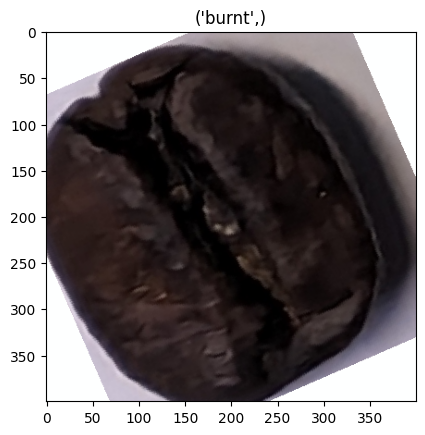

In [139]:
import numpy as np
from torchvision.utils import make_grid


def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloader))

# Make a grid from batch
out = make_grid(inputs)

imshow(out, title=classes)